# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

# Summary
********

In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pylab

# READ DATA
df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [2]:
# FUNCTIONS
def ecdf(data):
    """Compute ECDF for a 1-D array of measurements"""
    # Number of data points: n
    n = len(data)
    
    # x-data for ECDF: x
    x = np.sort(data)
    
    #y-data for ECDF: y
    y = np.arange(1, + n+1) / n
    
    return x, y


def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate"""
    return func(np.random.choice(data, size=len(data)))


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


def diff_of_means(data1, data2):
    """Difference in means of two arrays."""
    
    # The difference of means of data1, data2: diff
    diff = (np.mean(data1) - np.mean(data2))
    return diff


def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    
    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))
    
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
    
    # Split the permuted array into two: perm_sample1, perm_sample2
    perm_sample1 = permuted_data[:len(data1)]
    perm_sample2 = permuted_data[len(data1):]
    
    return perm_sample1, perm_sample2


def draw_perm_reps(data1, data2, func, size=1):
    """Generate multiple permutation replicates"""
    
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    
    for i in range(size):
        # Generate Permutation Sample
        perm_sample1, perm_sample2 = permutation_sample(data1, data2)
        
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample1, perm_sample2)
        
    return perm_replicates

***
### Question 1: Is the distribution of body temperatures normal?


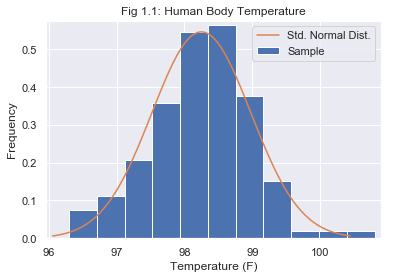

In [3]:
# Plot a histogram to see whether the distribution is normal
temp = df['temperature']
temp_mean = np.mean(temp)
temp_std = np.std(temp)

# Number of bins is square root of number of data points: n_bins
n_bins = int(np.sqrt(len(temp)))

# Plot histogram with appropriate labels
sns.set()
_ = plt.hist(df['temperature'], bins=n_bins, density = True)
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('Frequency')
_ = plt.title('Fig 1.1: Human Body Temperature')
_ = plt.margins(0.02)

# Overlay Standard Normal Distribution
x = np.linspace(temp_mean - 3*temp_std, temp_mean + 3*temp_std, 100)
plt.plot(x, stats.norm.pdf(x, temp_mean, temp_std))

# Plot a legend
_ = plt.legend(('Std. Normal Dist.', 'Sample'))

plt.show()

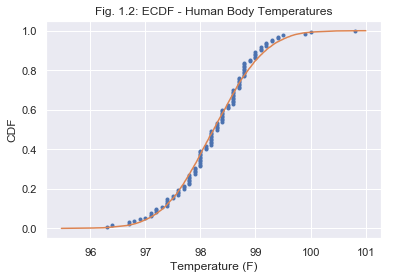

In [4]:
# Plot the Empirical Cumulative Distribution (ECDF)

# Call on ECDF function
x, y = ecdf(temp)

# Seed random number generator
np.random.seed(17)

# Repeated Trials for normal line
temp_reps = np.random.normal(temp_mean, temp_std, size=10000)
x_rep , y_rep = ecdf(temp_reps)


# Plot ECDF
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.plot(x_rep, y_rep)
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('CDF')
_ = plt.title('Fig. 1.2: ECDF - Human Body Temperatures')
margins = 0.02


plt.show();

**Analysis:**

Looking at the histogram above in Figure 1.1 it appears that the sample is normal for the most part. The distribution is unimodal. Figure 1.2 shows the frequency distribution of data. This too appears to be close to normal with the exception of a few outliers.

****

### Question 2: Is the sample size large? Are the observations independent?

In [5]:
# Count values in sample
df.count()

temperature    130
gender         130
heart_rate     130
dtype: int64

In [6]:
# Check if any values in df are null
df.isnull().any()

temperature    False
gender         False
heart_rate     False
dtype: bool

**Analysis**:

From the results above there are 130 observations in this dataset. For the purpose of the Central Limit Theorem, our sample **is large** because it is more than 30 observations. However in comparison to the entire human population it is quite minuscule.

Since each value is the body temperature of a different individual, we can say that they **are independent** observations.

****

### Question 3: Is the true population mean really 98.6 degrees F?

We are testing our sample of body temperatures to the true population mean 98.6 degrees F and therefore will be using a **one sample test at a significance level of 5%**

The hypotheses are:

$H_0:\ \bar x =$ 98.6° 
$H_a:\ \bar x \neq$ 98.6°


**3.1 Bootstrap Hypothesis test - 100,000 Samples**

In [7]:
# Seed random number generator
np.random.seed(17)

# Run Bootstrap Hypothesis Test
bs_replicates = draw_bs_reps(temp, np.mean, size=100000)

p = np.sum(bs_replicates >= 98.6) / len(bs_replicates)

print('p-value: ', p)

p-value:  0.0


Since the p-value is low, we can assume that our sample mean is different from the true population mean. To further confirm this we can use a one sample z-statistic test and one sample t-statistic test.

**3.2 Frequent Statistical Testing**

In [8]:
# Run One Sample z Test
# Calculate Standard Error
SE = temp_std / np.sqrt(len(temp))

z = (temp_mean - 98.6) / SE
p_zvalue = stats.norm.cdf(z) * 2
print('z-score: ', z)
print('p-value: ', p)

z-score:  -5.475925202078116
p-value:  0.0


The p-value of our z statistic allows us to again assume that our sample mean is different from the population mean. Let's see what happens when we use the t-statistic.

In [9]:
# Run One Sample t Test
t_test = stats.ttest_1samp(temp, 98.6)

t = t_test[0]
p_tvalue = t_test[1]

print('t-score: ', t)
print('p-value: ', p)

t-score:  -5.4548232923645195
p-value:  0.0


**Analysis:**

Looking at the different tests run we can **reject our null hypothesis and assume that the mean is not 98.6°F**. The p-value was extremely low for all three tests: bootstrap hypothesis test, one sample z test, and one sample t test. 

Although we ran both the z statistic and the t statistic, it is better to use the t statistic because we do not know the population standard deviation.

****

#### Question 4: Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [10]:
# Seed random number generator
np.random.seed(17)

# Choose a random sample of 10 datapoints from our previous sample
temp_small = np.random.choice(temp, size=10)

print(temp_small)

[98.  98.2 98.6 97.6 98.7 96.4 98.8 98.7 98.2 98.4]


In [11]:
# Run One Sample t Test
t_test = stats.ttest_1samp(temp_small, 98.6)

t_small = t_test[0]
p_tsmall = t_test[1]

print('t-score: ', t_small)
print('p-value: ', p_tsmall)

t-score:  -1.9287035862164446
p-value:  0.0858507359032994


In [12]:
# Run One Sample Z test
z_small = (np.mean(temp_small) - 98.6) / (np.std(temp_small) / np.sqrt(len(temp)))
p_zsmall = stats.norm.cdf(z_small) * 2

print('z-score: ', z_small)
print('p-value: ', p_zsmall)

z-score:  -7.330201437681887
p-value:  2.298070490675704e-13


**Analysis:**

Running both frequentist tests on a smaller sample size has us run into a pickle. The z-test tells us that we can reject the null hypothesis, while the t-test says we can't. However, since our dataset only has 10 samples, the z-test is not appropriate to use.

Therefore, based off the smaller sample size we randomly selected, we would **fail to reject the null hypothesis that the mean body temperature is 98.6°F.**

****

#### Question 5: At what temperature should we consider someone's temperature to be "abnormal"?

**5.1 Frequentist Method**

In [13]:
# Calculate Margin of Error and Confidence Interval: ME, CI
z_crit = 1.96
ME = z_crit * temp_std/ np.sqrt(1)
CI = [temp_mean - ME, temp_mean + ME]

print('95% Confidence Interval: ', CI)
print('Margin of Error: ', ME)

95% Confidence Interval:  [96.8177295225769, 99.68073201588466]
Margin of Error:  1.431501246653874


**5.2 Bootstrap**

In [14]:
# Seed random number generator
np.random.seed(17)

# Get set of 100000 set samples
temps = np.random.normal(temp_mean, temp_std, size = 100000)

# Calculate Margin of Error and Confidence Interval: ME, CI
z_crit = 1.96
ME = z_crit * np.std(temps)
CI = np.percentile(temps, [2.5, 97.5])

print('95% Confidence Interval: ', CI)
print('Margin of Error: ', ME)

95% Confidence Interval:  [96.82275279 99.67852207]
Margin of Error:  1.4311283179311125


**Analysis:**

With 95% confidence we can say that the true population mean lies approximately between 96.81°F and 99.68°F. In other words we are 95% confident that somebody would have "abnormal" temperature if it was not between 96.81°F and 99.68°F.

****

#### Question 6: Is there a significant difference between males and females in normal temperature?


To begin lets perform some EDA.

In [15]:
# Separate temperature data by male and female: temp_m, temp_f
temp_m = df.temperature[df.gender == 'M']
temp_f = df.temperature[df.gender =='F']

Male Sample Size:  65
Male Temperature Mean:  98.1046153846154

Female Sample Size:  65
Female Temperature Mean:  98.39384615384613 



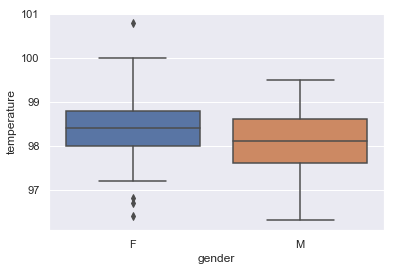

In [16]:
# Determine sample size: n_male, n_female
n_male = len(temp_m)
n_female = len(temp_f)

# Determine sample mean: m_male, m_female
m_male = np.mean(temp_m)
m_female = np.mean(temp_f)

# Determine standard deviation: std_male, std_female
std_male = np.std(temp_m)
std_female= np.std(temp_f)

print('Male Sample Size: ', n_male)
print('Male Temperature Mean: ', m_male)
print('\nFemale Sample Size: ', n_female)
print('Female Temperature Mean: ', m_female, '\n')

# Graphically represent data with a box plot
sns.boxplot(x = 'gender', y = 'temperature', data = df)

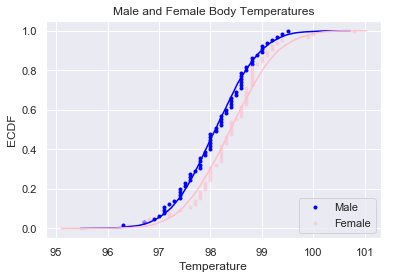

In [17]:
# Check if samples are normally distributed

x_m_temp, y_m_temp = ecdf(temp_m)
x_f_temp, y_f_temp = ecdf(temp_f)

# Seed random number generator
np.random.seed(17)

# Repeated Trials for normal line
temp_reps_m = np.random.normal(m_male, std_male, size=10000)
temp_reps_f = np.random.normal(m_female, std_female, size=10000)

x_rep_m, y_rep_m = ecdf(temp_reps_m)
x_rep_f, y_rep_f = ecdf(temp_reps_f) 


_ = plt.plot(x_m_temp, y_m_temp, marker ='.', linestyle = 'none', color = 'blue')
_ = plt.plot(x_f_temp, y_f_temp, marker = '.', linestyle = 'none', color = 'pink', alpha = 0.5)
_ = plt.plot(x_rep_m, y_rep_m, color = 'blue')
_ = plt.plot(x_rep_f, y_rep_f, color = 'pink')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.05)
_ = plt.title('Male and Female Body Temperatures')
_ = plt.legend(('Male', 'Female'), loc = 'lower right')

plt.show()

Based on the data above it appears that mean body temperature is higher for females than males. To determine if this is significant, we must do statistical analysis using a two sample permutation test.

Our hypotheses are:
<p>    $H_0: \mu_{females} - \mu_{males}$ = 0
<p>    $H_a: \mu_{females} - \mu_{males} \neq$ 0   
<p>at a significance level of $\alpha = 0.05$</p>


**6.1 Bootstrap Hypothesis Test**

In [18]:
# Set Random Seed Generator
np.random.seed(17)

# Calculate Difference in Mean Arrays: empirical_diff
empirical_diff = diff_of_means(temp_f, temp_m)

# Generate 100,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(temp_f, temp_m, diff_of_means, size=100000)

# Calculate p-value
p = np.sum(perm_replicates >= empirical_diff) / len(perm_replicates)

print('Difference of sample means: ', empirical_diff)
print('p-value: ', p)

Difference of sample means:  0.289230769230727
p-value:  0.01202


**6.2 Frequentist Statistical Testing**

In [19]:
# Two Sample t Test
t_test = stats.ttest_ind(temp_f, temp_m)

t = t_test[0]
p_value = t_test[1]

print('t-score: ', t)
print('p-value: ', p_value)

t-score:  2.2854345381656103
p-value:  0.02393188312239561


**Analysis:**

Based off the p-values obtained above, we can reject the null hypothesis. Although the significance wasn't that strong, women tend to have a slightly higher body temperature than men.